# General Setup

In [299]:
import json
import pandas as pd
import subprocess
import os

In [300]:
with open('data/curated/player_data_clean.json', 'r') as f:
	player_data = json.load(f)

In [301]:
df = pd.DataFrame(player_data)

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12760 entries, 0 to 15519
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   match_id                 12760 non-null  int64  
 1   match_start_time         12760 non-null  int64  
 2   account_id               12760 non-null  int64  
 3   name                     12760 non-null  object 
 4   fantasy_role             12760 non-null  object 
 5   hero_id                  12760 non-null  int64  
 6   hero_variant             12760 non-null  object 
 7   isRadiant                12760 non-null  bool   
 8   radiant_team_id          12760 non-null  int64  
 9   dire_team_id             12760 non-null  int64  
 10  tournament_start_date    12760 non-null  object 
 11  duration                 12760 non-null  int64  
 12  win                      12760 non-null  int64  
 13  kills                    12760 non-null  int64  
 14  deaths                   12

In [303]:
df = df.astype({
    'match_id': 'string',
    'account_id': 'string',
    'hero_id': 'string',
    'radiant_team_id': 'string',
    'dire_team_id': 'string',
    'win': 'boolean',
    'firstblood_claimed': 'boolean',
    'team_id': 'string',
	'enemy_team_id': 'string',
    'valveId': 'string',
})

## Set missing glicko scores to the first quartile
*Using the "..._clean" data set, this does not affect anything.*
Q1 was chosen, because teams that do not have a glicko 2 rating, usually are new or weaker teams.

In [304]:
q1_glicko = df['glicko2_rating'].quantile(0.25)
df['glicko2_rating'] = df['glicko2_rating'].fillna(q1_glicko)
q1_enemy_glicko = df['enemy_glicko2_rating'].quantile(0.25)
df['enemy_glicko2_rating'] = df['enemy_glicko2_rating'].fillna(q1_enemy_glicko)

In [305]:
mask = df['rating_advantage'].isna()
df.loc[mask, 'rating_advantage'] = df.loc[mask, 'glicko2_rating'] - df.loc[mask, 'enemy_glicko2_rating']

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12760 entries, 0 to 15519
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   match_id                 12760 non-null  string 
 1   match_start_time         12760 non-null  int64  
 2   account_id               12760 non-null  string 
 3   name                     12760 non-null  object 
 4   fantasy_role             12760 non-null  object 
 5   hero_id                  12760 non-null  string 
 6   hero_variant             12760 non-null  object 
 7   isRadiant                12760 non-null  bool   
 8   radiant_team_id          12760 non-null  string 
 9   dire_team_id             12760 non-null  string 
 10  tournament_start_date    12760 non-null  object 
 11  duration                 12760 non-null  int64  
 12  win                      12760 non-null  boolean
 13  kills                    12760 non-null  int64  
 14  deaths                   12

# XGBoost
Without time dimension.

In [307]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error


In [308]:
enemy_team_avg = df.groupby('enemy_team_id')['fantasy_score'].mean().rename('enemy_avg_fantasy_score')
df = df.merge(enemy_team_avg, left_on='enemy_team_id', right_index=True, how='left')

In [309]:
not_features = [
	'match_id', 'name', 'match_start_time', 'radiant_team_id', 'dire_team_id',
	'tournament_start_date', 'teamName', 'valveId', 'enemy_teamName', 'enemy_valveId', 'fantasy_score'
]

In [310]:
X = df.drop(columns=not_features)
y = df['fantasy_score']

In [312]:
X = pd.get_dummies(X, columns=['fantasy_role', 'hero_id', 'hero_variant', 'account_id', 'team_id', 'enemy_team_id'])


In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)#, random_state=1001)


In [314]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [315]:
y_pred = model.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 0.788373679000736


In [316]:
df[['team_id', 'enemy_team_id']].drop_duplicates()

,team_id,enemy_team_id
0,8599101,2163
5,2163,8599101
30,8599101,8291895
35,8291895,8599101
60,9247354,8291895
...,...,...
15305,8599101,8254145
15410,9729720,8291895
15415,8291895,9729720
15460,9247354,8254145


In [317]:
def build_prediction_rows(df, matchups, lineup_dir, rolling_n=20):
    rows = []
    for team_id, enemy_team_id in matchups:
        lineup_path = os.path.join(lineup_dir, f"team_lineup_{team_id}.json")
        if not os.path.exists(lineup_path):
            subprocess.run(["python", "get_current_lineups.py", str(team_id)])
        if not os.path.exists(lineup_path):
            continue  # Skip if still missing
        with open(lineup_path, "r", encoding="utf-8") as f:
            lineup = [p for p in json.load(f) if p.get("is_current_team_member")]
        for player in lineup:
            account_id = str(player["account_id"])
            player_hist = df[df["account_id"] == account_id].sort_values("match_start_time")
            if player_hist.empty:
                continue
            numeric_cols = player_hist.select_dtypes(include='number').columns.difference(
                ['match_id', 'account_id', 'radiant_team_id', 'dire_team_id', 'team_id', 'enemy_team_id', 'match_start_time']
            )
            rolling = player_hist[numeric_cols].tail(rolling_n).mean()
            row = player_hist.iloc[-1].copy()
            row[numeric_cols] = rolling
            row["team_id"] = team_id
            row["enemy_team_id"] = enemy_team_id
            rows.append(row)
    return pd.DataFrame(rows)

In [318]:
def predict_players_for_matchups(df, model, matchup_list, X, not_features, lineup_dir="data/lineups", rolling_n=20):
    # Ensure all lineup files exist (call API if not)
    team_ids = set()
    for t1, t2 in matchup_list:
        team_ids.add(t1)
        team_ids.add(t2)
    for team_id in team_ids:
        lineup_path = os.path.join(lineup_dir, f"team_lineup_{team_id}.json")
        if not os.path.exists(lineup_path):
            subprocess.run(["python", "get_current_lineups.py", str(team_id)])
    
    # Build synthetic prediction rows
    pred_df = build_prediction_rows(df, matchup_list, lineup_dir, rolling_n=rolling_n)
    if pred_df.empty:
        print("No eligible players found for the given matchups.")
        return pd.DataFrame()
    # Prepare features (same as training)
    X_pred = pred_df.drop(columns=not_features)
    X_pred = pd.get_dummies(X_pred, columns=['fantasy_role', 'hero_id', 'hero_variant', 'account_id', 'team_id', 'enemy_team_id'])
    X_pred = X_pred.reindex(columns=X.columns, fill_value=0)
    # print(X_pred.filter(like='enemy_team_id').head(10)) # Debugger, shows the dummy encoded enemy_team variable.
    # More debugging
    #rows = X_pred[X_pred['account_id_847565596'] == 1]  # print dummies for "rue"
    #print(rows[['enemy_team_id_7119388', 'enemy_team_id_8261500', 'enemy_team_id_8597976']])
    
    pred_df['predicted_fantasy_score'] = model.predict(X_pred) # Predict fantasy scores
    return pred_df[['account_id', 'name', 'fantasy_role', 'team_id', 'enemy_team_id', 'predicted_fantasy_score']]

In [319]:
def make_symmetric_matchups(matchups):
    symmetric = []
    for t1, t2 in matchups:
        symmetric.append((t1, t2))
        symmetric.append((t2, t1))
    return symmetric

In [320]:
matchups = [('7119388', '8261500'), ('8597976', '7119388'), ('8597976', '8261500')] # Spirit vs. Xtreme Gaming, Spirit vs. Talon
symetric_matchups = make_symmetric_matchups(matchups)
result = predict_players_for_matchups(df, model, symetric_matchups, X, not_features)

       enemy_team_id_7119388  enemy_team_id_8261500  enemy_team_id_8597976
14643                  False                   True                  False
14643                  False                  False                   True


In [321]:
result

,account_id,name,fantasy_role,team_id,enemy_team_id,predicted_fantasy_score
14641,113331514,Miposhka,Support,7119388,8261500,14.974798
14640,321580662,Yatoro,Core,7119388,8261500,19.452868
14644,302214028,Collapse,Core,7119388,8261500,10.221457
14642,106305042,Larl,Mid,7119388,8261500,16.658541
14643,847565596,rue,Support,7119388,8261500,15.128365
6689,203351055,Malik,Core,7119388,8261500,10.910934
14976,137129583,Xm,Mid,8261500,7119388,12.378320
14978,157475523,XinQ,Support,8261500,7119388,17.175344
14977,129958758,Xxs,Core,8261500,7119388,9.874105
14975,898754153,Ame,Core,8261500,7119388,15.579659


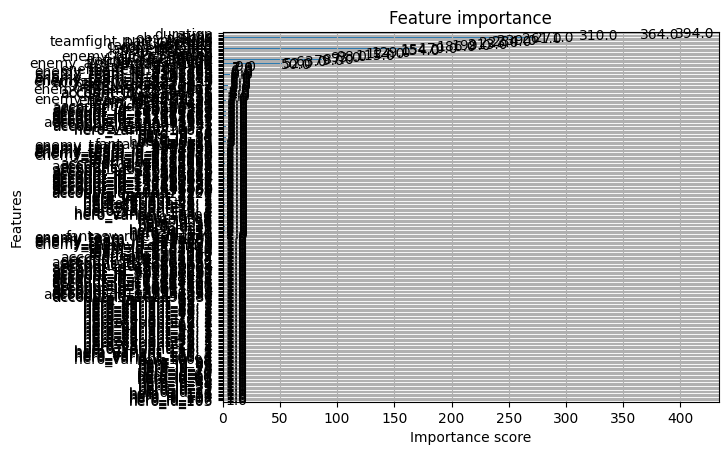

In [322]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})

In [323]:
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
3,kills,0.133525
14,firstblood_claimed,0.121317
2,win,0.085146
11,obs_placed,0.072300
8,towers_killed,0.070194
...,...,...
287,"hero_variant_41, 3",0.000000
286,"hero_variant_41, 2",0.000000
285,"hero_variant_40, 2",0.000000
284,"hero_variant_40, 1",0.000000


testing stuff

In [324]:
print(df['enemy_glicko2_rating'].describe())
print(df['enemy_glicko2_rating'].isna().sum())

count    12760.000000
mean      1933.887735
std        109.805301
min       1548.386055
25%       1851.277338
50%       1965.054843
75%       2022.311044
max       2101.693435
Name: enemy_glicko2_rating, dtype: float64
0


# Random Forest

In [328]:
from sklearn.ensemble import RandomForestRegressor


In [334]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2)

In [335]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=1001)
rf_model.fit(X_train_rf, y_train_rf)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [336]:
y_pred_rf = rf_model.predict(X_test_rf)
print("Random Forest RMSE:", root_mean_squared_error(y_test_rf, y_pred_rf))

Random Forest RMSE: 1.2865734187728994


In [337]:
matchups = [('7119388', '8261500'), ('8597976', '7119388'), ('8597976', '8261500')] # Spirit vs. Xtreme Gaming, Spirit vs. Talon
symetric_matchups = make_symmetric_matchups(matchups)
result = predict_players_for_matchups(df, rf_model, symetric_matchups, X, not_features)

       enemy_team_id_7119388  enemy_team_id_8261500  enemy_team_id_8597976
14643                  False                   True                  False
14643                  False                  False                   True


In [338]:
result

,account_id,name,fantasy_role,team_id,enemy_team_id,predicted_fantasy_score
14641,113331514,Miposhka,Support,7119388,8261500,15.843298
14640,321580662,Yatoro,Core,7119388,8261500,22.657751
14644,302214028,Collapse,Core,7119388,8261500,11.713624
14642,106305042,Larl,Mid,7119388,8261500,18.740002
14643,847565596,rue,Support,7119388,8261500,15.220170
6689,203351055,Malik,Core,7119388,8261500,10.711130
14976,137129583,Xm,Mid,8261500,7119388,13.681112
14978,157475523,XinQ,Support,8261500,7119388,16.684795
14977,129958758,Xxs,Core,8261500,7119388,11.063012
14975,898754153,Ame,Core,8261500,7119388,15.765444


In [340]:
rf_feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
rf_feature_importances

,feature,importance
3,kills,0.259411
15,stuns,0.163523
17,assists,0.088613
11,obs_placed,0.084708
8,towers_killed,0.081912
...,...,...
163,"hero_variant_104, 2",0.000000
387,"hero_variant_83, 1",0.000000
201,"hero_variant_126, 3",0.000000
164,"hero_variant_105, 1",0.000000


# LSTM
Wegen den Python-Version voraussetzungen von TensorFlow wird LSTM in einem eigenen Notebook implementiert.